# Assignment: histogram equalization for RGB images

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
sns.set(style='dark')

In [3]:
rgb = cv2.imread('fruits.jpg')[..., ::-1]
# rgb = cv2.imread('data/sunflowers.png')[..., ::-1]
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

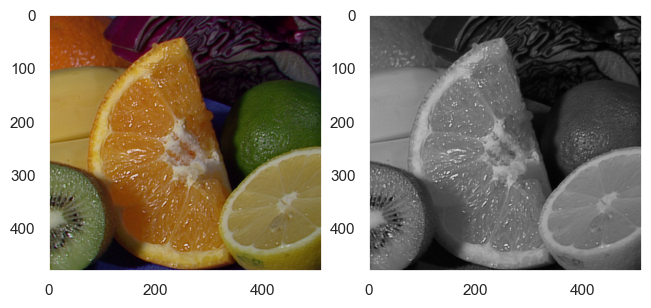

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, layout='constrained')
axes[0].imshow(rgb)
axes[1].imshow(gray, cmap='gray', vmin=0, vmax=255);

# Task 0: prepare the `create_histogram_equalization_lut` and `histogram_equalization` functions

You can just copy&paste the `create_histogram_equalization_lut` function from the lecture notebook. Note the usage of the `cdf` function.

In [5]:
def create_histogram_equalization_lut(h: np.ndarray) -> np.ndarray:
    # Calculate the cumulative distribution function (CDF) of the input histogram
    cdf = np.cumsum(h)
    # Normalize CDF to the range [0, 255]
    cdf = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    # Create the lookup table (LUT) by rounding CDF values to integers
    lut = cdf.round().astype(np.uint8)
    return lut

Prepare a function called `equalize_histogram`, that will take in a grayscale image (2D matrix) and output an equalized version of it.

In [6]:
def equalize_histogram(gray: np.ndarray) -> np.ndarray:
    # Calculate the histogram of the input grayscale image
    h = np.histogram(gray.ravel(), bins=np.arange(257))[0]
    # Create the histogram equalization lookup table (LUT)
    lut = create_histogram_equalization_lut(h)
    # Apply the LUT to the input image for equalization
    equalized = lut[gray]
    return equalized

The following should show the original grayscale image `gray` and its equalized version.

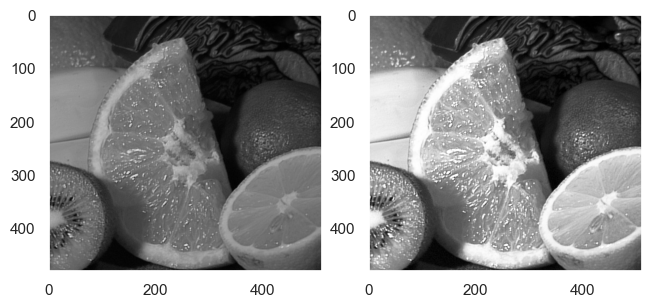

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, layout='constrained')
axes[0].imshow(gray, cmap='gray', vmin=0, vmax=255)
axes[1].imshow(equalize_histogram(gray), cmap='gray', vmin=0, vmax=255);

# Task 1: histogram equalization for R, G and B channels independently

1. Split the R, G and B channels from `rgb`.
2. Equalize each channel of the `rgb` image independently.
3. Stack them together to form the new equalized `rgb_indep` image.

In [8]:
# Split the R, G, and B channels from rgb
r_channel = rgb[:, :, 0]
g_channel = rgb[:, :, 1]
b_channel = rgb[:, :, 2]

# Equalize each channel of the rgb image independently
equalized_r = equalize_histogram(r_channel)
equalized_g = equalize_histogram(g_channel)
equalized_b = equalize_histogram(b_channel)

# Stack them together to form the new equalized rgb_indep image
rgb_indep = np.stack((equalized_r, equalized_g, equalized_b), axis=-1)


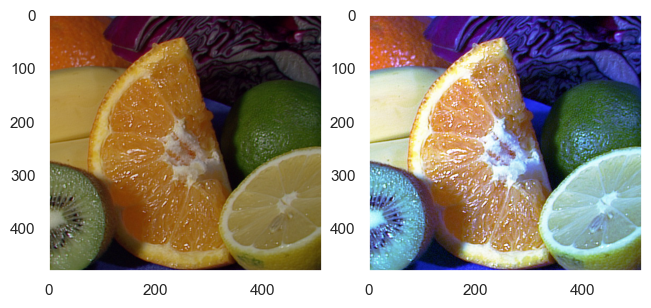

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, layout='constrained')
axes[0].imshow(rgb)
axes[1].imshow(rgb_indep);

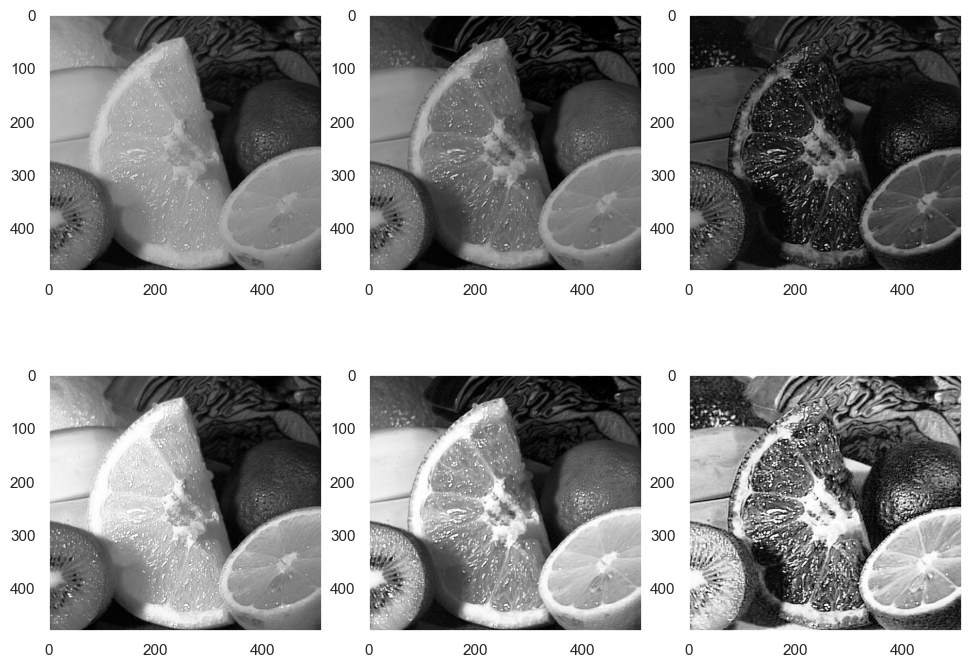

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=3, layout='constrained', figsize=(1.5*plt.rcParams['figure.figsize'][0], 1.5*plt.rcParams['figure.figsize'][1]))
for c in range(3):
    axes[0, c].imshow(rgb[..., c], cmap='gray', vmin=0, vmax=255)  # original c-th channel
    axes[1, c].imshow(rgb_indep[..., c], cmap='gray', vmin=0, vmax=255)  # independently equalized c-th channel

# Task 2: equalize the brightness/luminance

1. Convert to YUV/YCbCr/HSV/Lab/... or any other color space of your choice that separates the brightness/luminance from colors.
2. Equalize the brigthness/luminance channel only.
3. Convert back to RGB to form `rgb_lum`.

In [11]:
# Convert RGB to YUV color space
yuv_image = cv2.cvtColor(rgb, cv2.COLOR_RGB2YUV)

# Split the Y (luminance) channel from YUV
y_channel = yuv_image[:, :, 0]

# Equalize the luminance channel
equalized_y = equalize_histogram(y_channel)

# Replace the original Y channel with the equalized Y channel
yuv_image[:, :, 0] = equalized_y

# Convert back to RGB to form rgb_lum
rgb_lum = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2RGB)


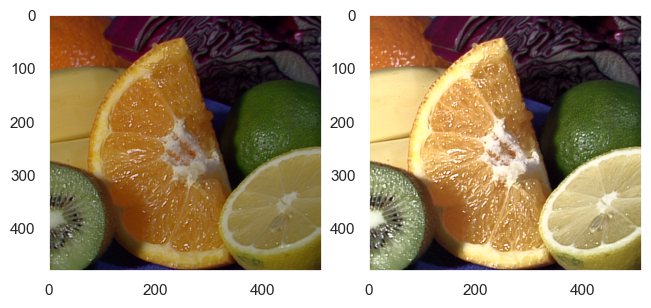

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, layout='constrained')
axes[0].imshow(rgb)
axes[1].imshow(rgb_lum);

# Task 3: equalize using transformation LUT computed from grayscale image

1. Convert `rgb` to grayscale (use the `gray` image from above).
2. Compute the histogram equalization lookup table from the grayscale image.
3. Apply this same LUT to every channel of the `rgb` image to form the new `rgb_gray` equalized image.

In [25]:
# Convert RGB to grayscale using the existing 'gray' image
gray_image = gray

# Compute the histogram equalization lookup table (LUT)
lut = create_histogram_equalization_lut(gray_image).astype(np.uint8)

# Ensure the LUT has 256 elements (for 8-bit images)
if len(lut) < 256:
    lut = np.concatenate((lut, np.zeros(256 - len(lut), dtype=np.uint8)))

# Apply the LUT to every channel of the RGB image manually
rgb_gray = np.zeros_like(rgb, dtype=np.uint8)

for c in range(3):
    rgb_gray[..., c] = lut[rgb[..., c]]

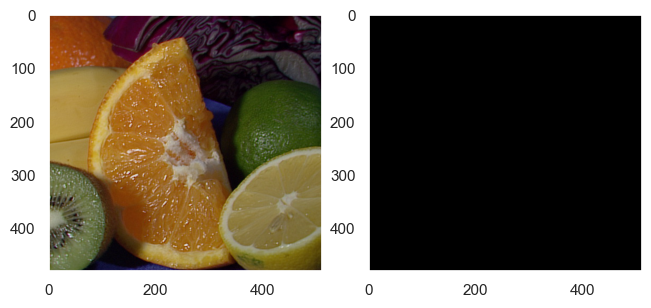

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, layout='constrained')
axes[0].imshow(rgb)
axes[1].imshow(rgb_gray);

# Task 4 (optional): implement `create_lut` function

Implement the function `create_lut` that will create a custom brightness transformation lookup table based on user's input. It's inputs are
- `points`: list of `(a, b)` pairs such that brightness `a` maps to `b` in the resulting table
Returns:
- `q_enh`: lookup table as a vector of 256 values of type `np.ndarray` with shape `(256,)`

User specifies arbitrarily-sized sparse `list` of `(p, q)` pairs of which input brightness `a` should map to which output brightness `b`. Everything in-between should be interpolated. For example `create_lut([(0, 255), (255, 0)])` should return the same lookup table as `lut_neg` from the lecture notebook, because in this example `a=0` maps to `q=255`, `a=255` maps to `b=0` and everything inbetween will be linearly interpolated.

If the user's list starts from a pair in which `a > 0` or ends with a pair in which `a < 255`, then all values less than the smallest `a` will be mapped to a value of the `b` from the same pair. E.g. if the input list is `[(100, 100), (200, 200)]`, all values of `0 <= a < 100` will map to `b=100` and all values `200 < a < 256` will map to `b=200`.

In [27]:
def create_lut(points: list[tuple[int, int]]) -> np.ndarray:
    """
    Create a lookup table for arbitrary brightness transformation.
    """
    if len(points) == 0:
        # If no points are provided, return an identity LUT
        return np.arange(256)

    # Sort the points by input brightness 'a'
    points.sort(key=lambda x: x[0])

    # Initialize the LUT
    lut = np.zeros(256, dtype=np.uint8)

    # Handle values before the first point (a < points[0][0])
    for a in range(points[0][0]):
        lut[a] = points[0][1]

    for i in range(len(points) - 1):
        a1, b1 = points[i]
        a2, b2 = points[i + 1]

        for a in range(a1, a2 + 1):
            # Linear interpolation between (a1, b1) and (a2, b2)
            lut[a] = int(b1 + (a - a1) * (b2 - b1) / (a2 - a1))

    # Handle values after the last point (a > points[-1][0])
    for a in range(points[-1][0], 256):
        lut[a] = points[-1][1]

    return lut


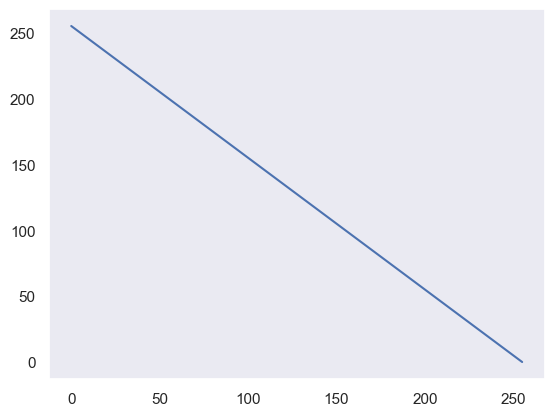

In [28]:
# lookup table for negative
plt.plot(create_lut([(0, 255), (255, 0)]));

In [29]:
# lookup table for thresholding
lut_thr = create_lut([(0, 0), (100, 0), (101, 255), (255, 255)])

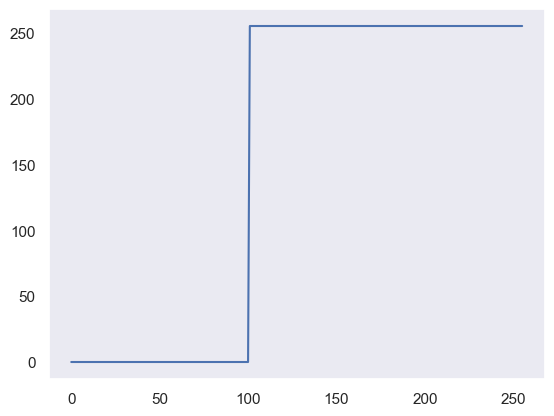

In [30]:
plt.plot(lut_thr);

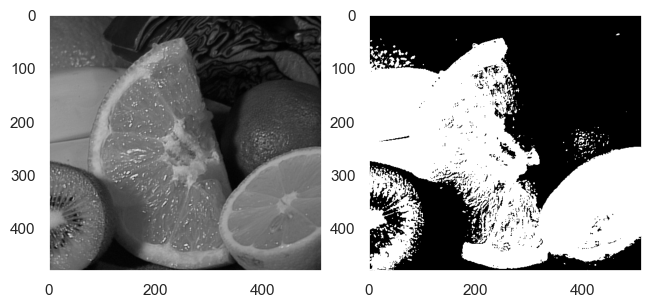

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, layout='constrained')
axes[0].imshow(gray, cmap='gray', vmin=0, vmax=255);
axes[1].imshow(lut_thr[gray], cmap='gray', vmin=0, vmax=255);

In [32]:
# lookup table for contrast enhancement
lut_enh = create_lut([(0, 0), (50, 10), (200, 245), (255, 255)])

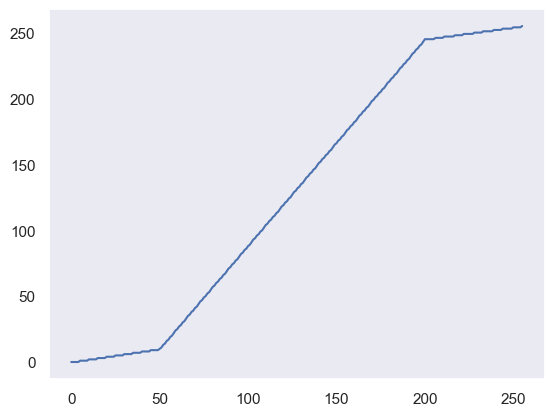

In [33]:
plt.plot(lut_enh);

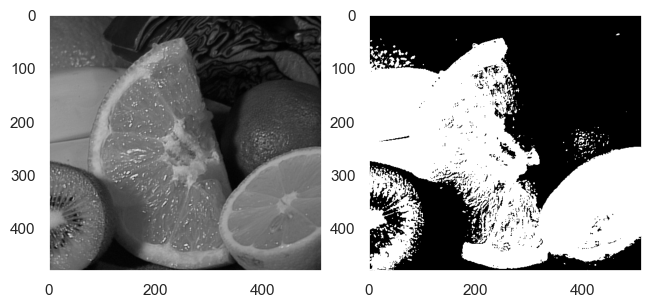

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, layout='constrained')
axes[0].imshow(gray, cmap='gray', vmin=0, vmax=255);
axes[1].imshow(lut_thr[gray], cmap='gray', vmin=0, vmax=255);